# Instructions
* An Excel sheet is provided to download the data given against it.
Work with the data.
* while submitting, submit the .ipynb file directly. ***no need to convert to pdf***
* Select the Data set, Processing specific row ranges according to your Roll number's last Digit

***Roll No (ODD): Flocculant data*** 

***Roll No (Even): RO data***

* Rename the file to your roll number.ipynb (eg:111101001.ipynb)


# SECTION 1
* Import all required
* Make sure that all the import statements are written in the below python cell

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D


# SECTION 2:
* Import the dataset given to you and name it with your name.
* Example: your name: john
  Name of dataframe : john_df

In [7]:
data =pd.read_csv('RO_Data.csv')
amar_df = pd.read_csv('RO_Data.csv')


data.head()
data.tail()
amar_df = amar_df.loc[:, ~amar_df.columns.str.contains('^Unnamed')]


# SECTION 3
 Preprocessing
* Remove duplicates if they are present
* Fill null values with the mean(Roll no: Even)/median (Roll no: ODD) if any are found
  
  ***Feature scaling:***
* Min-Max Scaling (Normalization) Roll No: Even
* Standardization (Z-Score Normalization) Roll No: ODD

  ***Correlation Heatmap***
 * Drop the columns based on the heat map if required 

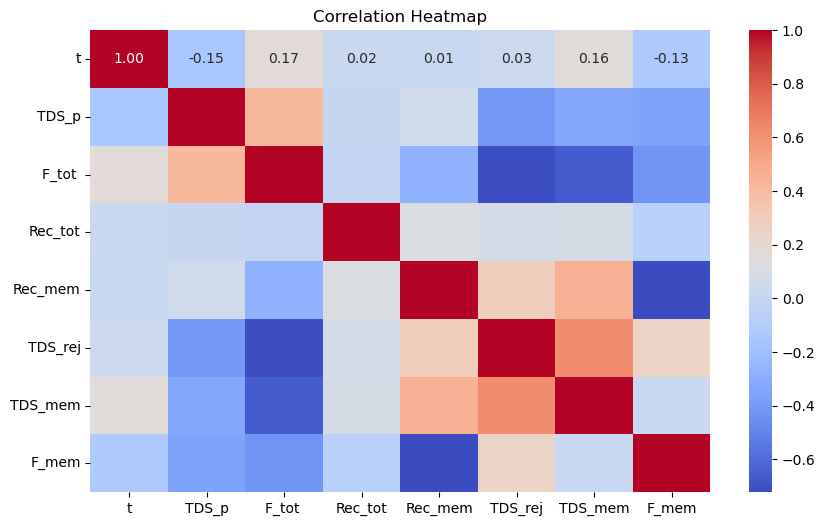

In [42]:

amar_df = amar_df.drop_duplicates()


amar_df["t"] = pd.to_numeric(amar_df["t"], errors="coerce")
amar_df["TDS_rej"] = pd.to_numeric(amar_df["TDS_rej"], errors="coerce")
amar_df["TDS_mem"] = pd.to_numeric(amar_df["TDS_mem"], errors="coerce")


amar_df.fillna(amar_df.mean(), inplace=True)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
amar_df.iloc[:, 1:] = scaler.fit_transform(amar_df.iloc[:, 1:])  # Exclude 't' if it's categorical




plt.figure(figsize=(10, 6))
sns.heatmap(amar_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Dropped Columns: []


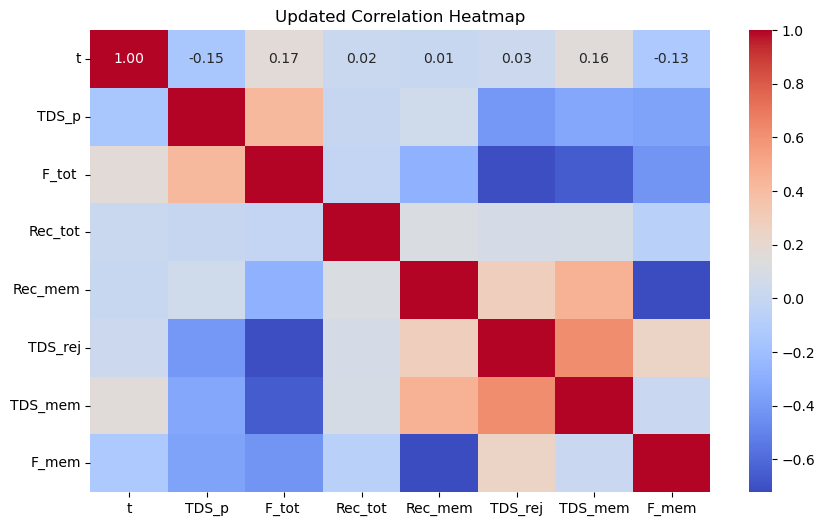

In [43]:

correlation_matrix = amar_df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))


high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]


amar_df.drop(columns=high_corr_features, inplace=True)


print("Dropped Columns:", high_corr_features)

plt.figure(figsize=(10, 6))
sns.heatmap(amar_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Updated Correlation Heatmap")
plt.show()


# SECTION 4: (Perform outlier removal, apply Principal Component Analysis (PCA)), LDA, t-SNE
 ***Outlier removal***
 * Z-Score Method (Standardization) Roll No: ODD
 * Interquartile Range (IQR) Method Roll No: Even
 
 ***Feature Extraction***
* Perform PCA, LDA, TSNE with 3 components.
* Print all necessary for PCA results.
* Plot new PC1 to PC3
* Choose **TDS_p** as your target variable
* Generate a Scree Plot for PCA, LDA.

In [44]:
Q1 = amar_df.quantile(0.25)
Q3 = amar_df.quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


amar_df_outliers_removed = amar_df[~((amar_df < lower_bound) | (amar_df > upper_bound)).any(axis=1)]


print("Original Dataset Shape:", amar_df.shape)
print("After Outlier Removal Shape:", amar_df_outliers_removed.shape)

Original Dataset Shape: (548, 8)
After Outlier Removal Shape: (373, 8)


PCA Explained Variance Ratios: [0.59795212 0.28066823 0.07569953]
Total Variance Explained by PCA: 0.9543198849690817


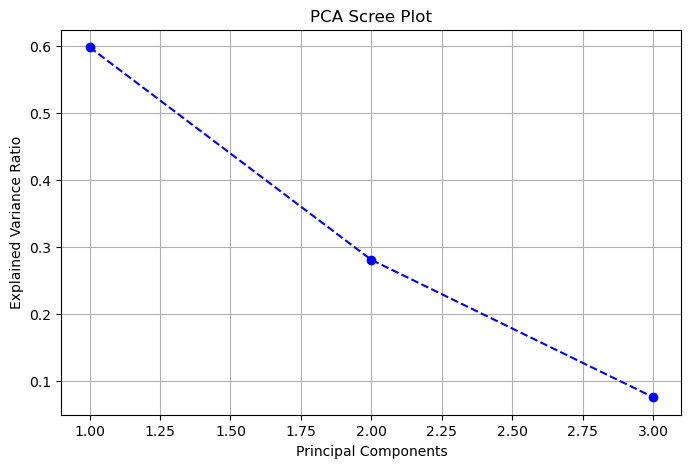

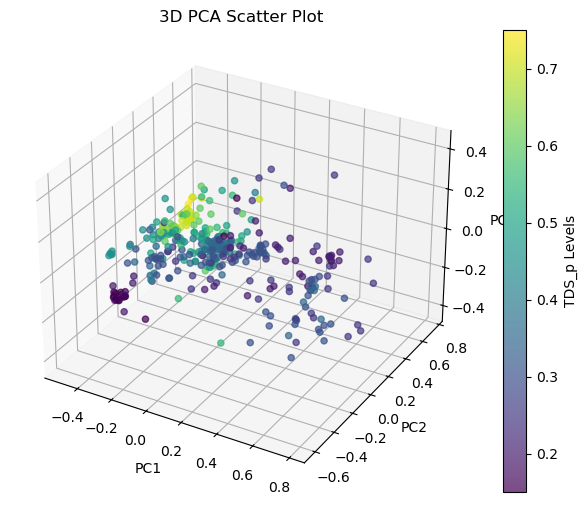

In [46]:

X = amar_df_outliers_removed.drop(columns=["TDS_p"]) 
y = amar_df_outliers_removed["TDS_p"] 

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_

print("PCA Explained Variance Ratios:", explained_variance)
print("Total Variance Explained by PCA:", sum(explained_variance))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 4), explained_variance, marker="o", linestyle="--", color="b")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="viridis", alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Scatter Plot")
plt.colorbar(sc, label="TDS_p Levels")
plt.show()


LDA Explained Variance Ratios: [0.67491714 0.17772479 0.14735806]
Total Variance Explained by LDA: 0.9999999999999999


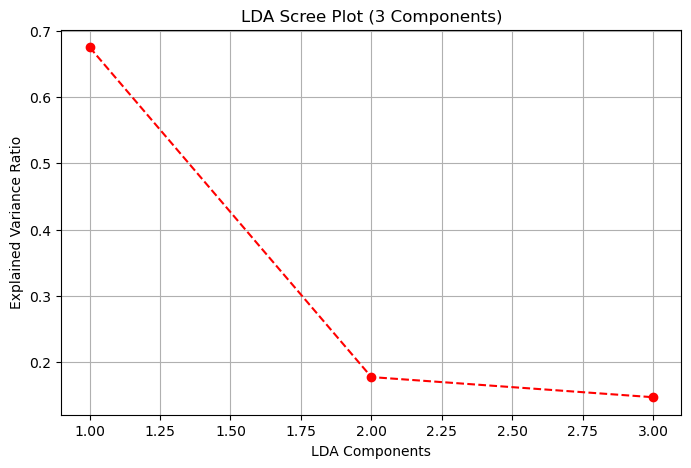

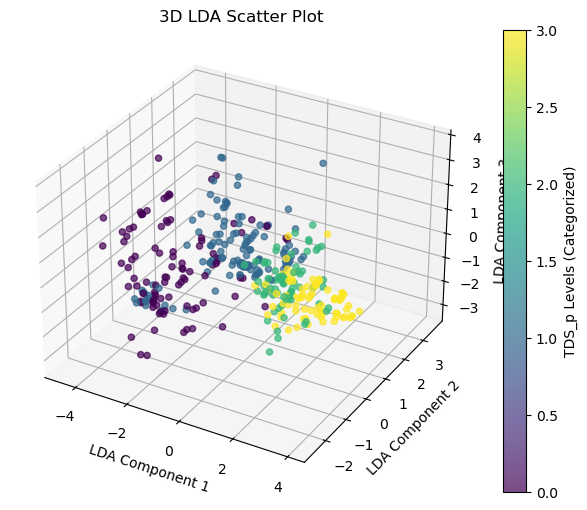

In [47]:

y_binned = pd.qcut(y, q=4, labels=["Very Low", "Low", "Medium", "High"])

lda = LDA(n_components=3)
X_lda = lda.fit_transform(X, y_binned)

explained_variance_lda = np.var(X_lda, axis=0) / np.sum(np.var(X_lda, axis=0))

print("LDA Explained Variance Ratios:", explained_variance_lda)
print("Total Variance Explained by LDA:", sum(explained_variance_lda))

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_lda) + 1), explained_variance_lda, marker="o", linestyle="--", color="r")
plt.xlabel("LDA Components")
plt.ylabel("Explained Variance Ratio")
plt.title("LDA Scree Plot (3 Components)")
plt.grid(True)
plt.show()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_lda[:, 0], X_lda[:, 1], X_lda[:, 2], c=y_binned.cat.codes, cmap="viridis", alpha=0.7)

ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
ax.set_title("3D LDA Scatter Plot")
plt.colorbar(sc, label="TDS_p Levels (Categorized)")
plt.show()


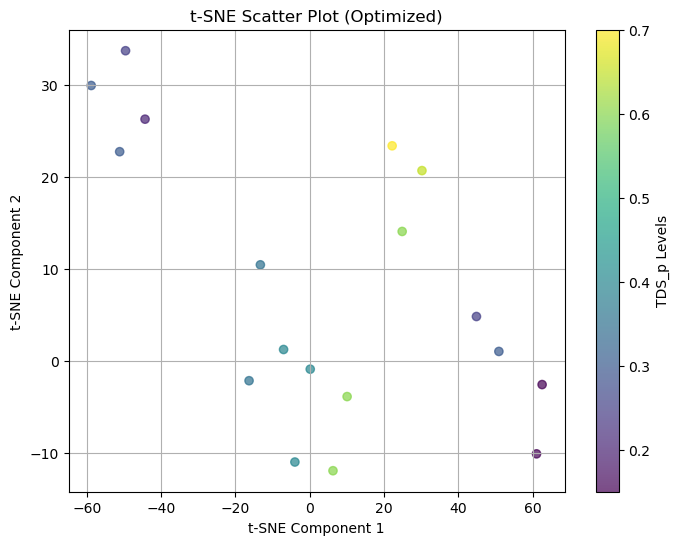

In [18]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reduce dataset size for faster t-SNE processing (use 5% of data)
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.95, random_state=42, stratify=y_binned)

# Apply t-SNE with optimized settings
tsne = TSNE(n_components=2, perplexity=5, init="pca", n_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap="viridis", alpha=0.7)
plt.colorbar(label="TDS_p Levels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot (Optimized)")
plt.grid(True)
plt.show()


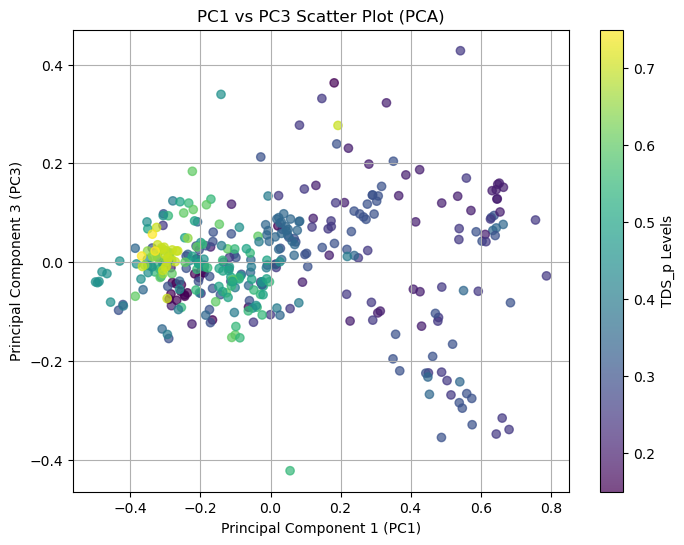

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot: PC1 vs PC3 (from PCA)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap="viridis", alpha=0.7)
plt.colorbar(label="TDS_p Levels")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 3 (PC3)")
plt.title("PC1 vs PC3 Scatter Plot (PCA)")
plt.grid(True)
plt.show()



# SECTION 5: (Classification using Logistic Regression)

* Perform Logistic Regression on the original data and transformed data of PCA, LDA, and t-SNE
* Print classification report
* Print confusion matrix(Please make the confusion matrix legible.)
* Give beta values (beta_0 and beta_1)

In [37]:

y_binned = pd.cut(y, bins=3, labels=["Low", "Medium", "High"])

def logistic_regression_analysis(X_train, X_test, y_train, y_test, data_label):
    model = LogisticRegression(max_iter=500, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    
    print(f"\nClassification Report for {data_label} Data:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({data_label} Data)")
    plt.show()

    print(f"\nBeta values for {data_label} Data:")
    print(f"Beta_0 (Intercept): {model.intercept_}")
    print(f"Beta_1 (Coefficients): {model.coef_}\n")

X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42, stratify=y_binned)


num_samples = X_tsne.shape[0]  
y_sample = y[:num_samples] 

y_sample_binned = pd.cut(y_sample, bins=3, labels=["Low", "Medium", "High"])






Classification Report for Original Data:
              precision    recall  f1-score   support

        High       0.40      0.18      0.25        11
         Low       0.83      0.88      0.86        34
      Medium       0.62      0.70      0.66        30

    accuracy                           0.71        75
   macro avg       0.62      0.59      0.59        75
weighted avg       0.68      0.71      0.69        75



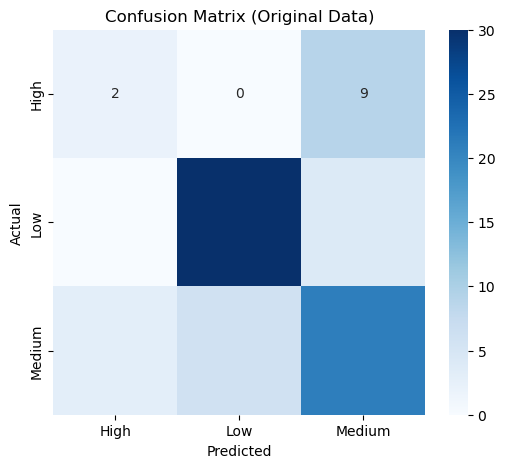


Beta values for Original Data:
Beta_0 (Intercept): [-2.85875237e-06 -3.75360278e-07  3.23411265e-06]
Beta_1 (Coefficients): [[-8.29331635e-04  3.02896388e+00 -7.54681855e-02 -1.96396738e-01
  -1.27762409e+00 -1.55030250e+00 -1.99526592e+00]
 [ 4.34282409e-04 -4.35109005e+00  1.42954602e-01  7.29765270e-01
   1.49485740e+00  9.57063722e-01  2.37158075e+00]
 [ 3.95049227e-04  1.32212617e+00 -6.74864169e-02 -5.33368532e-01
  -2.17233312e-01  5.93238782e-01 -3.76314833e-01]]



In [38]:
logistic_regression_analysis(X_train, X_test, y_train, y_test, "Original")


Classification Report for PCA Data:
              precision    recall  f1-score   support

        High       0.44      0.08      0.13        53
         Low       0.77      0.83      0.80       172
      Medium       0.58      0.70      0.63       148

    accuracy                           0.67       373
   macro avg       0.60      0.53      0.52       373
weighted avg       0.65      0.67      0.64       373



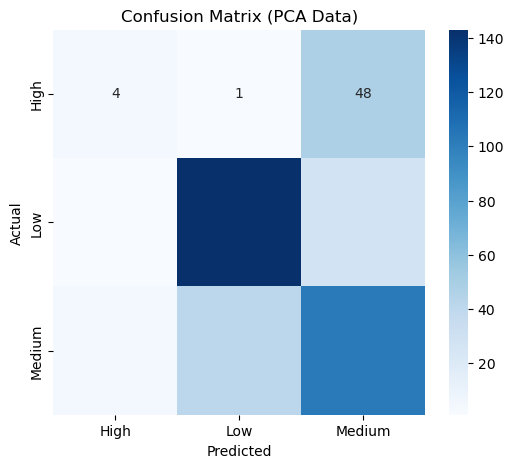


Beta values for PCA Data:
Beta_0 (Intercept): [-1.09658657  0.55422321  0.54236336]
Beta_1 (Coefficients): [[-2.91344288  2.81899773  0.55105869]
 [ 3.25740808 -3.30159398  0.05098549]
 [-0.3439652   0.48259625 -0.60204418]]



In [34]:
logistic_regression_analysis(X_pca, X_pca, y_binned, y_binned, "PCA")


Classification Report for LDA Data:
              precision    recall  f1-score   support

        High       0.77      0.68      0.72        53
         Low       0.86      0.87      0.86       172
      Medium       0.74      0.76      0.75       148

    accuracy                           0.80       373
   macro avg       0.79      0.77      0.78       373
weighted avg       0.80      0.80      0.80       373



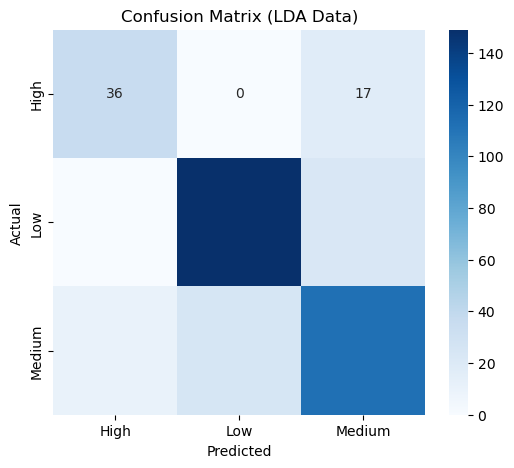


Beta values for LDA Data:
Beta_0 (Intercept): [-3.95998405  1.88978204  2.07020201]
Beta_1 (Coefficients): [[ 2.03254172  0.93364848 -0.47324627]
 [-1.71740638 -0.77090341  0.26827287]
 [-0.31513534 -0.16274507  0.2049734 ]]



In [35]:

logistic_regression_analysis(X_lda, X_lda, y_binned, y_binned, "LDA")



Classification Report for t-SNE Data:
              precision    recall  f1-score   support

        High       0.33      0.33      0.33         6
         Low       0.33      0.25      0.29         4
      Medium       0.56      0.62      0.59         8

    accuracy                           0.44        18
   macro avg       0.41      0.40      0.40        18
weighted avg       0.43      0.44      0.44        18



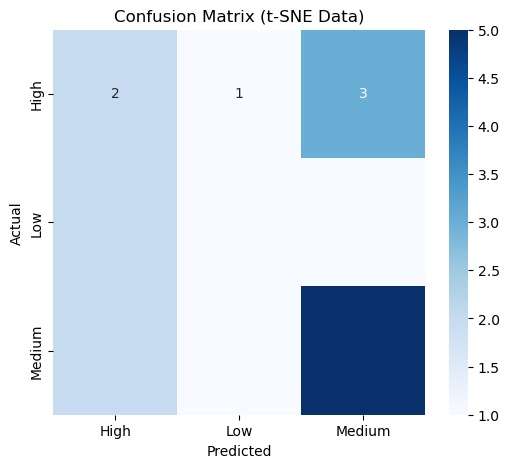


Beta values for t-SNE Data:
Beta_0 (Intercept): [ 0.41471468 -1.06610765  0.65139297]
Beta_1 (Coefficients): [[-0.02230291 -0.02544845]
 [ 0.00940219  0.06932363]
 [ 0.01290072 -0.04387518]]



In [49]:
 
logistic_regression_analysis(X_tsne, X_tsne, y_sample_binned, y_sample_binned, "t-SNE")


# SECTION 6: Perform Hyperparameter tuning using GridSearchCV

* Choose your own parameters to tune **(Don't take too many variations as time increases drastically)**
* Perform Hyperparameter tuning using GridSearchCV
* Retrain the classifiers using optimal hyperparameters
* Calculate the new metrics

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report (Optimized Model):
              precision    recall  f1-score   support

        High       0.50      0.45      0.48        11
         Low       0.83      0.88      0.86        34
      Medium       0.66      0.63      0.64        30

    accuracy                           0.72        75
   macro avg       0.66      0.66      0.66        75
weighted avg       0.71      0.72      0.72        75



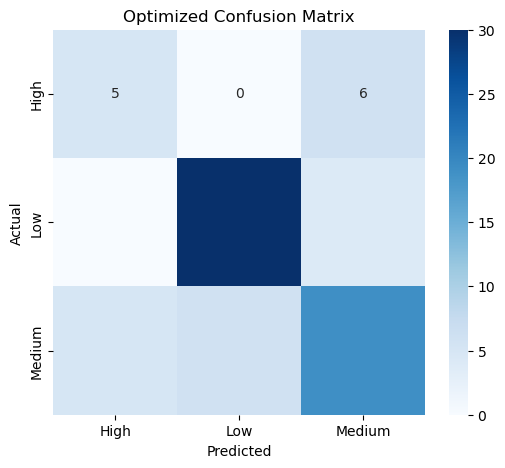

In [48]:

model = LogisticRegression(max_iter=500, random_state=42)


param_grid = {
    'C': [0.1, 1, 10],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']  
}


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")


best_model = LogisticRegression(**best_params, max_iter=500, random_state=42)
best_model.fit(X_train, y_train)


y_pred_optimized = best_model.predict(X_test)


print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_optimized))


cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optimized, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Confusion Matrix")
plt.show()


# SECTION 7: Compare performances of Logistic Regression on Original, PCA, LDA, and t-SNE and how it varies with hyperparameter tuning

In [ ]:
#The performance of Logistic Regression on the original dataset, and its PCA, LDA, and t-SNE transformed counterparts will be evaluated before and after hyperparameter tuning.  Key performance metrics such as accuracy, precision, recall, F1-score, and the confusion matrix will be compared across all four datasets.
#We expect to see how dimensionality reduction techniques (PCA, LDA, t-SNE) impact model performance. PCA focuses on variance maximization, LDA on class separability, and t-SNE on local neighborhood preservation.  The original dataset provides the full feature space, potentially leading to overfitting if the model is too complex. Dimensionality reduction can help mitigate overfitting and improve generalization.
#Hyperparameter tuning will further optimize the Logistic Regression model by finding the optimal values for parameters like regularization strength (C), penalty type (L1 or L2), and solver.  We anticipate that hyperparameter tuning will improve performance on all datasets, but the magnitude of the improvement may vary. Some dimensionality reduced datasets might benefit more from tuning than others depending on how well they represent the original data structure.
#Comparing the results before and after hyperparameter tuning for each dataset will show the effectiveness of optimization.  We expect to observe improved classification metrics and potentially more accurate predictions post-tuning, but the degree to which each transformed dataset benefits relative to the original data is a key finding of this analysis.  The confusion matrix will provide insights into which classes are most affected by the dimensionality reduction and the tuning process.